# Predicting people's heights

### Say we have two populations. 

Population `1` has :
- an average height of 155 cm for females
- standard deviation of 4
- average height of 175 cm for males
- with a standard deviation of 5 

Population `2` has: 
- an average height of 165 cm for females
- with a standarddeviation of 15
- average height of 185 cm for males
- standard deviation of 12 

### We decide to take 200 males and 200 females from each population.

In [1]:
import numpy as np

# Nº os samples:
n = 200

In [2]:
# Generating random samples from a normal gaussian distribution
height_pop1_f = np.random.normal(loc=155, scale=4, size=n)
height_pop1_m = np.random.normal(loc=175, scale=5, size=n)
height_pop2_f = np.random.normal(loc=165, scale=15, size=n)
height_pop2_m = np.random.normal(loc=185, scale=12, size=n)

In [3]:
# We group all females together and all males together
height_f = np.concatenate([height_pop1_f, height_pop2_f])
height_m = np.concatenate([height_pop1_m, height_pop2_m])

In [4]:
import pandas as pd

# label 1 = female and 2 = male
df_height = pd.DataFrame({'Gender': [1 for i in range(height_f.size)] +
                          [2 for i in range(height_m.size)],
                          'Height': np.concatenate((height_f, height_m))})

In [5]:
df_height

,Gender,Height
0,1,154.552789
1,1,148.377204
2,1,155.868969
3,1,153.947964
4,1,153.571907
...,...,...
795,2,184.019698
796,2,183.301816
797,2,172.798531
798,2,185.511930


Let's plot our fictional data using histograms to see the height distributions among each
gender:

/home/anandaheino/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


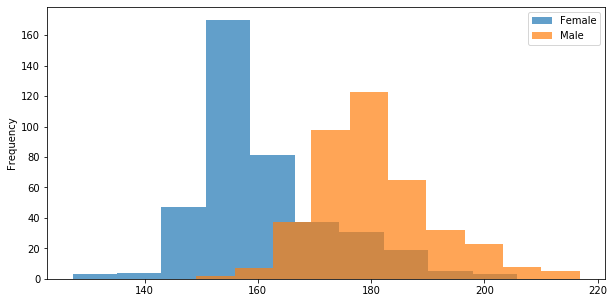

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize=(10, 5))

df_height[df_height['Gender'] == 1]['Height'].plot(
    label='Female', kind='hist', bins=10, alpha=0.7, ax=ax)

df_height[df_height['Gender'] == 2]['Height'].plot(
    label='Male', kind= 'hist', bins=10, alpha=0.7, ax=ax)

ax.legend()
fig.show()

## The resulting distributions are not symmetrical. 

Although normal distributions are symmetrical, these artificial distributions are made of two sub-distributions combined. 

We can use this line of code to see that their mean and median are different:


In [7]:
df_height.groupby('Gender')[['Height']].agg([np.mean, np.median]).round(2)

Height        
          mean  median
Gender                
1       160.78  157.69
2       180.52  178.71

### 1 FEATURE: gender
### TERGET: height  

In [10]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_height, test_size=0.3)

x_train, x_test = df_train[['Gender']], df_test[['Gender']]
y_train, y_test = df_train[['Height']], df_test[['Height']]

In regression we want the members of each group to have target values that are as close as possible to the predictions they make. 

### scikit-learn implements two criteria to achieve this goal:

1) Mean absolute error (MAE or L1)

2) Mean squared error (MSE or L2)

## Let's now compare the effect of the splitting criteria on our height dataset:

In [16]:
from sklearn.tree import export_text
from sklearn.tree import DecisionTreeRegressor

for criterion in ['mse', 'mae']:
    rgrsr = DecisionTreeRegressor(criterion=criterion)    # Here we pass the Criterion, MSE or MAE
    rgrsr.fit(x_train, y_train)
    print(f'\ncriterion=\033[33m{criterion}\033[m:\n')
    print(export_text(rgrsr, feature_names=['Gender'], spacing=3,decimals=1))   # Showing the Decision tree


criterion=mse:

|--- Gender <= 1.5
|   |--- value: [160.1]
|--- Gender >  1.5
|   |--- value: [180.5]


criterion=mae:

|--- Gender <= 1.5
|   |--- value: [157.3]
|--- Gender >  1.5
|   |--- value: [178.7]



In [7]:
df_height.groupby('Gender')[['Height']].agg([np.mean, np.median]).round(2)

Height        
          mean  median
Gender                
1       160.78  157.69
2       180.52  178.71

### As expected:
- whit MSE, the predictions were close to the mean of each gender
- whit MAE, the predictions were close to the median.

# Regressor's evaluation

The very same MSE and MAE scores can also be used to evaluate a regressor's accuracy.

We use them to compare the regressor's predictions to the actual targets in the test set

In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

for criterion in ['mse', 'mae']:
    rgrsr = DecisionTreeRegressor(criterion=criterion)    # Here we pass the Criterion, MSE or MAE
    rgrsr.fit(x_train, y_train)
    y_test_pred = rgrsr.predict(x_test)
    print(f'\ncriterion=\033[33m{criterion}\033[m:\n')
    print('\nMSE:', mean_squared_error(y_test, y_test_pred))
    print('\nMAE:', mean_absolute_error(y_test, y_test_pred))
    
print('--'*50)


criterion=mse:


MSE: 138.18951878642125

MAE: 9.023771869667803

criterion=mae:


MSE: 150.1739596990521

MAE: 8.954301928129262
----------------------------------------------------------------------------------------------------


## -  Using MAE as the splitting criterion: gives a lower MAE at test time.
## - Using MSE as the splitting criterion: gives a lower MSE at test time. 

So, if the aim is to reduce the predictions errors (based on a certain metric), it is
advised to use the same metric when growing your tree at the time of training.

# Setting sample weights

Both the decision tree classifiers and the regressors allow us to give more or less emphasis to the individual training samples via setting their weights while fitting. 

This is a common feature in many estimators, and decision trees are no exception here. 

To see the effect of sample weights, we are going to give 10 times more weight to users above 150 cm versus the remaining users:

In [26]:
y_train['Height']

424    167.378955
684    181.078168
750    185.035894
313    164.224056
517    177.444166
          ...    
58     157.288365
109    156.522893
168    155.687277
583    177.599959
245    166.322864
Name: Height, Length: 560, dtype: float64

In [30]:
rgrsr = DecisionTreeRegressor(criterion='mse')
sample_weight = y_train['Height'].apply(lambda h: 10 if h > 150 else 1)
rgrsr.fit(x_train, y_train, sample_weight=sample_weight)

print(f'\ncriterion=\033[33m MSE \033[m:\n')
print(export_text(rgrsr, feature_names=['Gender'], spacing=3,decimals=1))   # Showing the Decision tree


criterion= MSE :

|--- Gender <= 1.5
|   |--- value: [161.3]
|--- Gender >  1.5
|   |--- value: [180.5]



In [31]:
rgrsr = DecisionTreeRegressor(criterion='mae')
sample_weight = y_train['Height'].apply(lambda h: 10 if h <= 150 else 1)
rgrsr.fit(x_train, y_train, sample_weight=sample_weight)

print(f'\ncriterion=\033[33m MAE \033[m:\n')
print(export_text(rgrsr, feature_names=['Gender'], spacing=3,decimals=1))   # Showing the Decision tree


criterion= MAE :

|--- Gender <= 1.5
|   |--- value: [151.1]
|--- Gender >  1.5
|   |--- value: [178.7]

